# **SIR Model based study on covid 19 cases**
data taken from WHO site

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.integrate import odeint
from scipy.optimize import least_squares

In [35]:
#code to read excel file
file_path = "/content/drive/MyDrive/Papollo-Healtcare-Dataset.xlsx"

df = pd.read_excel(file_path)


In [36]:
print("Available columns:")
print(df.columns)

# Auto detect date column
DATE_COL = None
for col in df.columns:
    if "date" in col.lower() or "time" in col.lower():
        DATE_COL = col
        break

if DATE_COL is None:
    raise Exception("No date column found. Please check your dataset.")

print("Detected Date Column:", DATE_COL)

# Ensure date column is datetime and sorted in the original DataFrame
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)

# User wants to use 'Diagnosis' to derive active cases. We will create a daily count of patients admitted,
# which represents new cases for the day.
daily_cases_df = df.groupby(DATE_COL).size().reset_index(name='daily_diagnosis_count')

# Set the global ACTIVE_COL to the new derived column name
ACTIVE_COL = 'daily_diagnosis_count'

# Replace the original 'df' with the aggregated 'daily_cases_df' for subsequent SIR model steps.
# This 'df' now contains the time series of active cases.
df = daily_cases_df.copy()

print(f"Derived Active Cases Column: {ACTIVE_COL}")
print("\nFirst 5 rows of the derived daily cases data for SIR model:")
print(df.head())

Available columns:
Index(['Patient_ID', 'Admit_Date', 'Discharge_Date', 'Diagnosis',
       'Bed_Occupancy', 'Test', 'Doctor', 'Followup Date', 'Feedback',
       'Billing Amount', 'Health Insurance Amount'],
      dtype='object')
Detected Date Column: Admit_Date
Derived Active Cases Column: daily_diagnosis_count

First 5 rows of the derived daily cases data for SIR model:
  Admit_Date  daily_diagnosis_count
0 2022-12-05                      1
1 2022-12-06                      1
2 2022-12-07                      1
3 2022-12-08                      1
4 2022-12-09                      1


# **now preparing the data**


In [37]:
df[ACTIVE_COL] = df[ACTIVE_COL].fillna(method="ffill")

t = np.arange(len(df))
I_obs = df[ACTIVE_COL].values.astype(float)

# ---- Auto detect population if present, else set default ----
pop_col = None
for col in df.columns:
    if "pop" in col.lower():
        pop_col = col
        break

if pop_col:
    N = float(df[pop_col].iloc[0])
    print("Population column detected:", pop_col)
else:
    N = 1000000   # Default value if not in dataset
    print("Population not found in dataset. Using default:", N)

I0 = max(I_obs[0], 1)
R0 = 0
S0 = N - I0 - R0

Population not found in dataset. Using default: 1000000


/tmp/ipython-input-671764049.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[ACTIVE_COL] = df[ACTIVE_COL].fillna(method="ffill")


# *Making the SIR model*

In [38]:
def sir(y, t, beta, gamma):
    S, I, R = y
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return [dS, dI, dR]

def solve_sir(beta, gamma, time_array):
    y0 = [S0, I0, R0]
    sol = odeint(sir, y0, time_array, args=(beta, gamma))
    return sol.T

In [39]:
def error(params):
    beta, gamma = params
    _, I_pred, _ = solve_sir(beta, gamma, t) # Pass 't' as the time_array
    return I_pred - I_obs

initial_guess = [0.3, 0.1]

fit = least_squares(error, initial_guess, bounds=([0,0],[5,5]))

beta, gamma = fit.x

print("Estimated beta:", beta)
print("Estimated gamma:", gamma)
print("Estimated R0 (Reproduction number):", beta/gamma)

Estimated beta: 1.6698614750016934
Estimated gamma: 1.6593622981473046
Estimated R0 (Reproduction number): 1.006327235990664


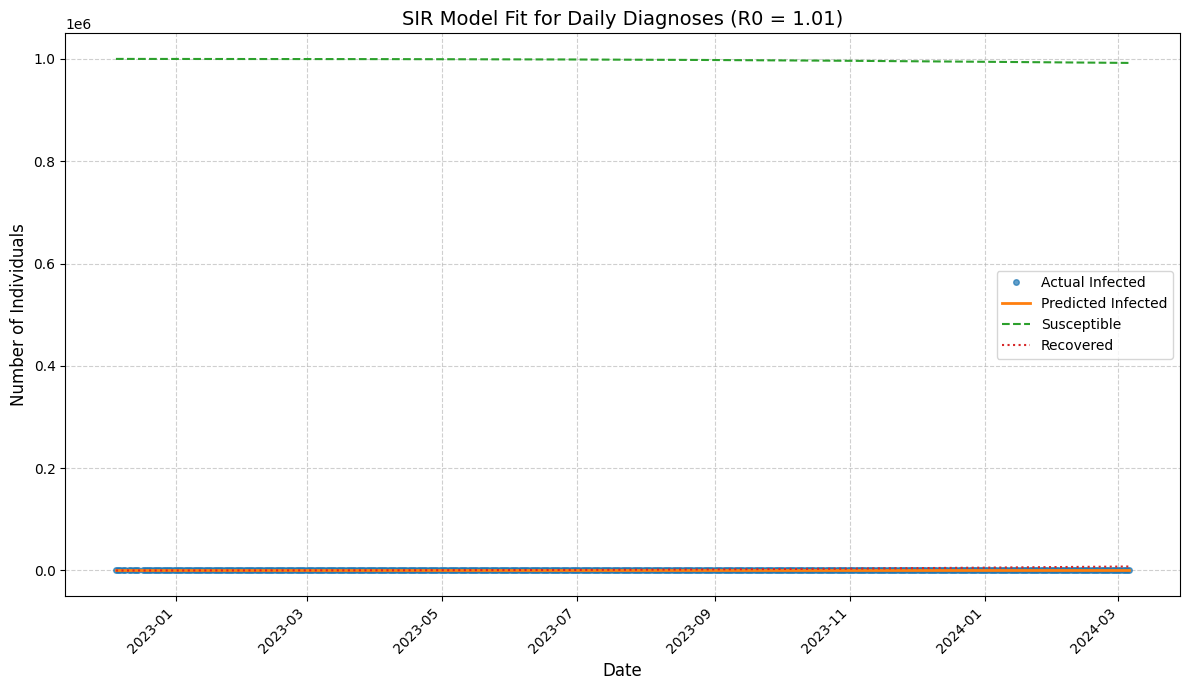

In [41]:
S_fit, I_fit, R_fit = solve_sir(beta, gamma, t)

plt.figure(figsize=(12, 7)) # Increased figure size
plt.plot(df[DATE_COL], I_obs, 'o', label="Actual Infected", markersize=4, alpha=0.7) # Added markers and alpha for actual data
plt.plot(df[DATE_COL], I_fit, '-', label="Predicted Infected", linewidth=2) # Line for predicted infected
plt.plot(df[DATE_COL], S_fit, '--', label="Susceptible", linewidth=1.5) # Dashed line for susceptible
plt.plot(df[DATE_COL], R_fit, ':', label="Recovered", linewidth=1.5) # Dotted line for recovered

plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Individuals", fontsize=12)
plt.title(f"SIR Model Fit for Daily Diagnoses (R0 = {beta/gamma:.2f})", fontsize=14)
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right') # Rotate dates for better readability
plt.grid(True, linestyle='--', alpha=0.6) # Added a grid
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [42]:
df["S_pred"] = S_fit
df["I_pred"] = I_fit
df["R_pred"] = R_fit

df.to_excel("sir_model_output.xlsx", index=False)
print("File saved as: sir_model_output.xlsx")


File saved as: sir_model_output.xlsx


learning from the model


### **Prediction for Future Days**
Let's extend our SIR model to predict the disease trajectory for a future period. We will use the estimated `beta` and `gamma` values to forecast the number of susceptible, infected, and recovered individuals for an additional number of days beyond our current dataset.

In [43]:
# Number of days to predict into the future
future_days = 60

# Create an extended time array for prediction
t_extended = np.arange(len(df) + future_days)

# Solve the SIR model with the estimated beta and gamma for the extended period
# Pass t_extended to solve_sir
S_pred_extended, I_pred_extended, R_pred_extended = solve_sir(beta, gamma, t_extended)

# Create an extended date range for plotting
last_date = df[DATE_COL].iloc[-1]
dates_extended = pd.date_range(start=df[DATE_COL].iloc[0], periods=len(t_extended), freq='D')

# Find the peak of predicted infections
peak_infected_index = np.argmax(I_pred_extended)
peak_infected_value = I_pred_extended[peak_infected_index]
peak_infected_date = dates_extended[peak_infected_index]

print(f"Predicted peak of infected individuals: {int(peak_infected_value)} on {peak_infected_date.strftime('%Y-%m-%d')}")

Predicted peak of infected individuals: 20 on 2024-01-18


### **Visualizing Extended SIR Model Predictions**
This plot shows the actual observed infected cases along with the extended predictions for Susceptible, Infected, and Recovered populations.

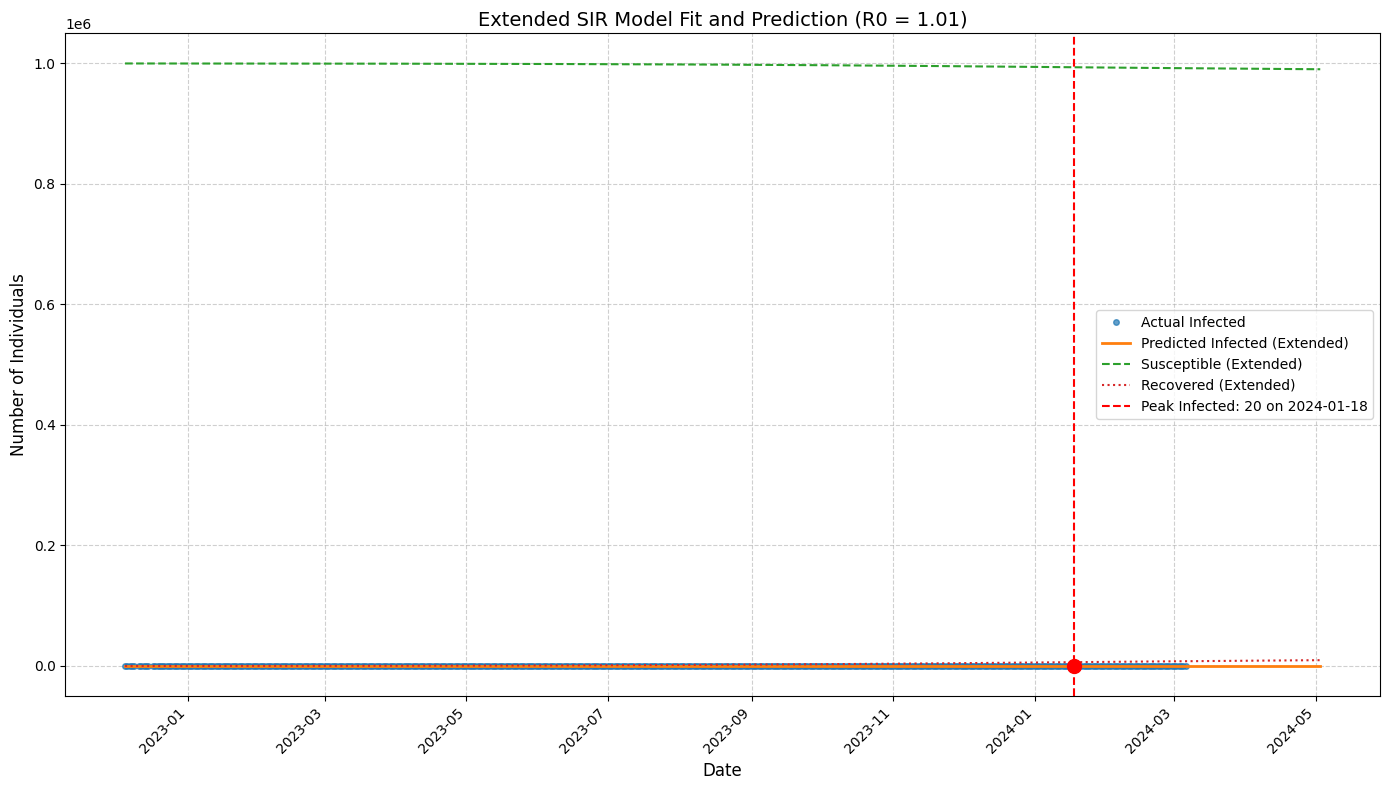

In [44]:
plt.figure(figsize=(14, 8))
plt.plot(df[DATE_COL], I_obs, 'o', label="Actual Infected", markersize=4, alpha=0.7)
plt.plot(dates_extended, I_pred_extended, '-', label="Predicted Infected (Extended)", linewidth=2)
plt.plot(dates_extended, S_pred_extended, '--', label="Susceptible (Extended)", linewidth=1.5)
plt.plot(dates_extended, R_pred_extended, ':', label="Recovered (Extended)", linewidth=1.5)

# Mark the predicted peak of infections
plt.axvline(x=peak_infected_date, color='r', linestyle='--', label=f'Peak Infected: {int(peak_infected_value)} on {peak_infected_date.strftime("%Y-%m-%d")}')
plt.scatter(peak_infected_date, peak_infected_value, color='red', s=100, zorder=5)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Individuals", fontsize=12)
plt.title(f"Extended SIR Model Fit and Prediction (R0 = {beta/gamma:.2f})", fontsize=14)
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


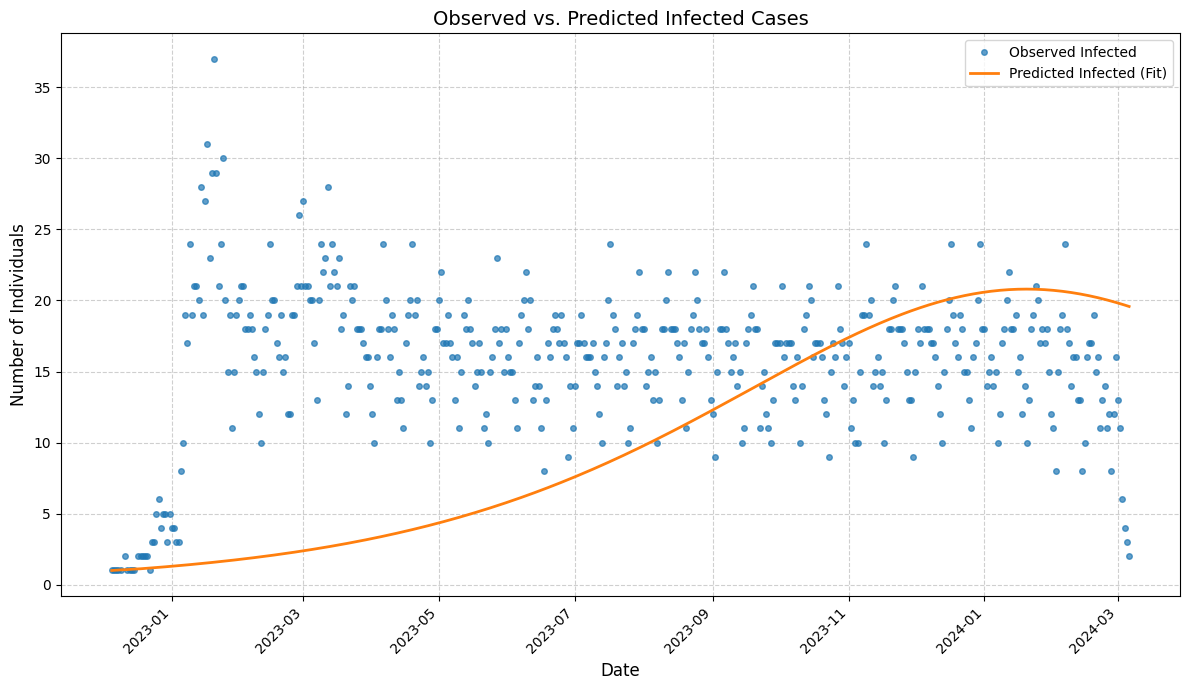

In [45]:
plt.figure(figsize=(12, 7))
plt.plot(df[DATE_COL][:len(I_obs)], I_obs, 'o', label="Observed Infected", markersize=4, alpha=0.7)
plt.plot(df[DATE_COL][:len(I_fit)], I_fit, '-', label="Predicted Infected (Fit)", linewidth=2)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Individuals", fontsize=12)
plt.title("Observed vs. Predicted Infected Cases", fontsize=14)
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()